<a href="https://www.kaggle.com/code/henilj7/anime-recommendation?scriptVersionId=118766456" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed 
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python 
# For example, here's several helpful packages to load 
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
# Input data files are available in the read-only "../input/" directory 
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory import os for dirname, _, filenames in os.walk('/kaggle/input'): for filename in filenames: print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Notebook Color Scheme:


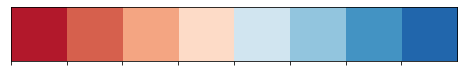

In [2]:
from IPython.display import display_html
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.patches as patches
import warnings
from wordcloud import WordCloud
from collections import defaultdict
from PIL import Image
import pandas as pd
import seaborn as sns
import numpy as np
# Environment check
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
import IPython.display as display
%matplotlib inline
from IPython.display import IFrame
from IPython.display import HTML
from collections import defaultdict
# Custom colors

# The code defines a class clr with two class attributes S and E.

# The S attribute is a string that represents an ANSI escape sequence. 
# ANSI escape sequences are used to control the formatting of text in a terminal,including color. 
# In this case, '\033[1m' sets the text to bold and
# '\033[95m' sets the text color to light magenta.

# The E attribute is a string that represents another ANSI escape sequence,
# which resets the formatting back to its default values.


class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m' + '\033[94m'
    
# my_colors = ["#AF0848", "#E90B60", "#CB2170", "#954E93", "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
my_colors=["#b2182b","#d6604d","#f4a582","#fddbc7","#d1e5f0","#92c5de","#4393c3","#2166ac"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()



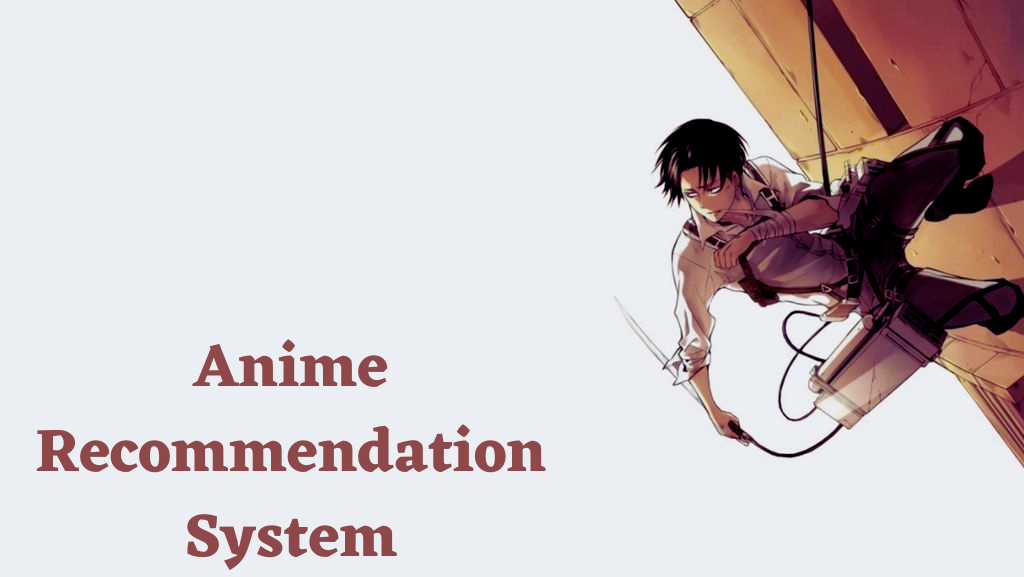

In [3]:
# Open an image
img = Image.open("/kaggle/input/imagesused/Anime Recommendation System title.png")

# Display the image
display.display(img)


In [4]:
# Insert image in Plot 
def insert_image(path, zoom, xybox, ax):
    imagebox = OffsetImage(mpimg.imread(path), zoom=zoom)
    ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), frameon=False, pad=1, xybox=xybox)
    ax.add_artist(ab)
    
def similar_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    '''Creates a custom function for the color of the wordcloud.'''
    
    h = 270 # 0 - 360 <- the color hue
    s = 40 # 0-100 <- the color saturation
    l = random_state.randint(30, 70) # 0 - 100 <- gradient
    
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [5]:
anime_df=pd.read_csv("/kaggle/input/anime-recommendations-database/anime.csv")
rating_df=pd.read_csv("/kaggle/input/anime-recommendations-database/rating.csv")

In [6]:
print("\n",clr.S+"Anime Dataframe Size:"+clr.E, anime_df.shape)
display_html(anime_df.head(3).style.set_properties(**{'border-style': 'solid', 'border-width': '1px'}).set_table_styles([{'selector': 'th','props': [('background-color', '#C9C9C9'), ('color', 'black')]}]))
print("\n",clr.S+"Raiting Dataframe Size:"+clr.E, rating_df.shape)
display_html(rating_df.head(3).style.set_properties(**{'border-style': 'solid', 'border-width': '1px'}).set_table_styles([{'selector': 'th','props': [('background-color', '#C9C9C9'), ('color', 'black')]}]))


 Anime Dataframe Size: (12294, 7)


anime_id 
 name 
 genre 
 type 
 episodes 
 rating 
 members 
 
 
 
 
 0 
 32281 
 Kimi no Na wa. 
 Drama, Romance, School, Supernatural 
 Movie 
 1 
 9.370000 
 200630 
 
 
 1 
 5114 
 Fullmetal Alchemist: Brotherhood 
 Action, Adventure, Drama, Fantasy, Magic, Military, Shounen 
 TV 
 64 
 9.260000 
 793665 
 
 
 2 
 28977 
 Gintama° 
 Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen 
 TV 
 51 
 9.250000 
 114262


 Raiting Dataframe Size: (7813737, 3)


user_id 
 anime_id 
 rating 
 
 
 
 
 0 
 1 
 20 
 -1 
 
 
 1 
 1 
 24 
 -1 
 
 
 2 
 1 
 79 
 -1

In [7]:
anime_df.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [8]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [9]:
anime_fulldata=pd.merge(anime_df,rating_df,on='anime_id',suffixes= ['', '_user'])
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_title', 'rating_user': 'user_rating'})
anime_fulldata.head().style.set_properties(**{'border-style': 'solid', 'border-width': '1px'}).set_table_styles([{'selector': 'th','props': [('background-color', '#C9C9C9'), ('color', 'black')]}])

In [10]:
anime_fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7813727 entries, 0 to 7813726
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   anime_id     int64  
 1   anime_title  object 
 2   genre        object 
 3   type         object 
 4   episodes     object 
 5   rating       float64
 6   members      int64  
 7   user_id      int64  
 8   user_rating  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 596.1+ MB


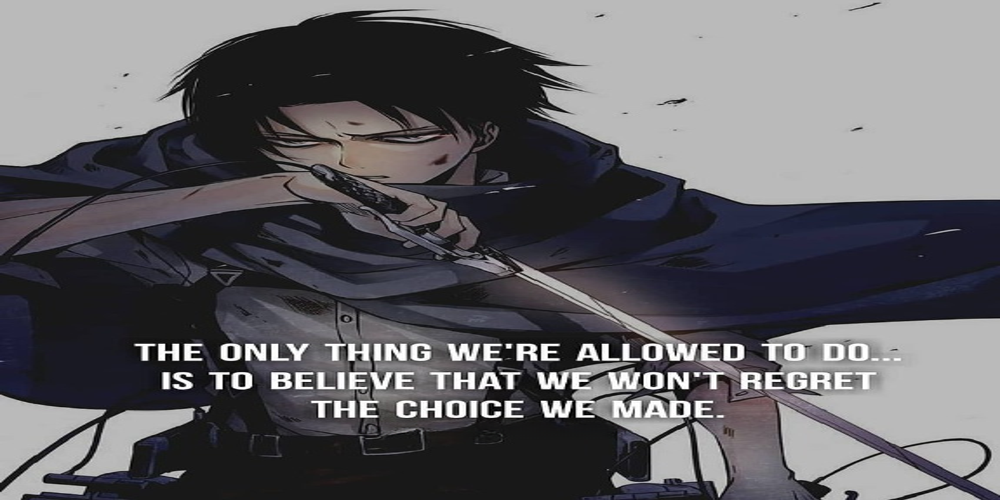

In [11]:

# Calculate the number of missing values for each column
missing_values_count = anime_fulldata.isna().sum()

# Create a table from the missing values count
table = missing_values_count.to_frame(name='Missing Values Count')

# Show the table in the Kaggle notebook

display.display(table.style.set_properties(**{'border-style': 'solid', 'border-width': '1px'}).set_table_styles([{'selector': 'th','props': [('background-color', '#1F2033'), ('color', '#EFEEEF')]}]))

# Open an image
img = Image.open("/kaggle/input/imagesused/levi.jpg")
img = img.resize((1000, 500))
# Display the image
display.display(img)

In [12]:
#drop the records with response missing in data.
df = anime_fulldata[~anime_fulldata.isnull()].copy()
df.dropna(axis='rows',inplace=True)
df.isnull().sum()

anime_id       0
anime_title    0
genre          0
type           0
episodes       0
rating         0
members        0
user_id        0
user_rating    0
dtype: int64

In [13]:
print(clr.S+"After Merging and cleaning data our dataframe size:"+clr.E, df.shape)

After Merging and cleaning data our dataframe size: (7813611, 9)



<div style="text-align:center;">
<img src="https://th.bing.com/th/id/OIP.tR2_nhBRJbB5j0RGe5imBgHaEO?pid=ImgDet&rs=1" alt="death Note" style="width:700px;height:400px;">
</div>




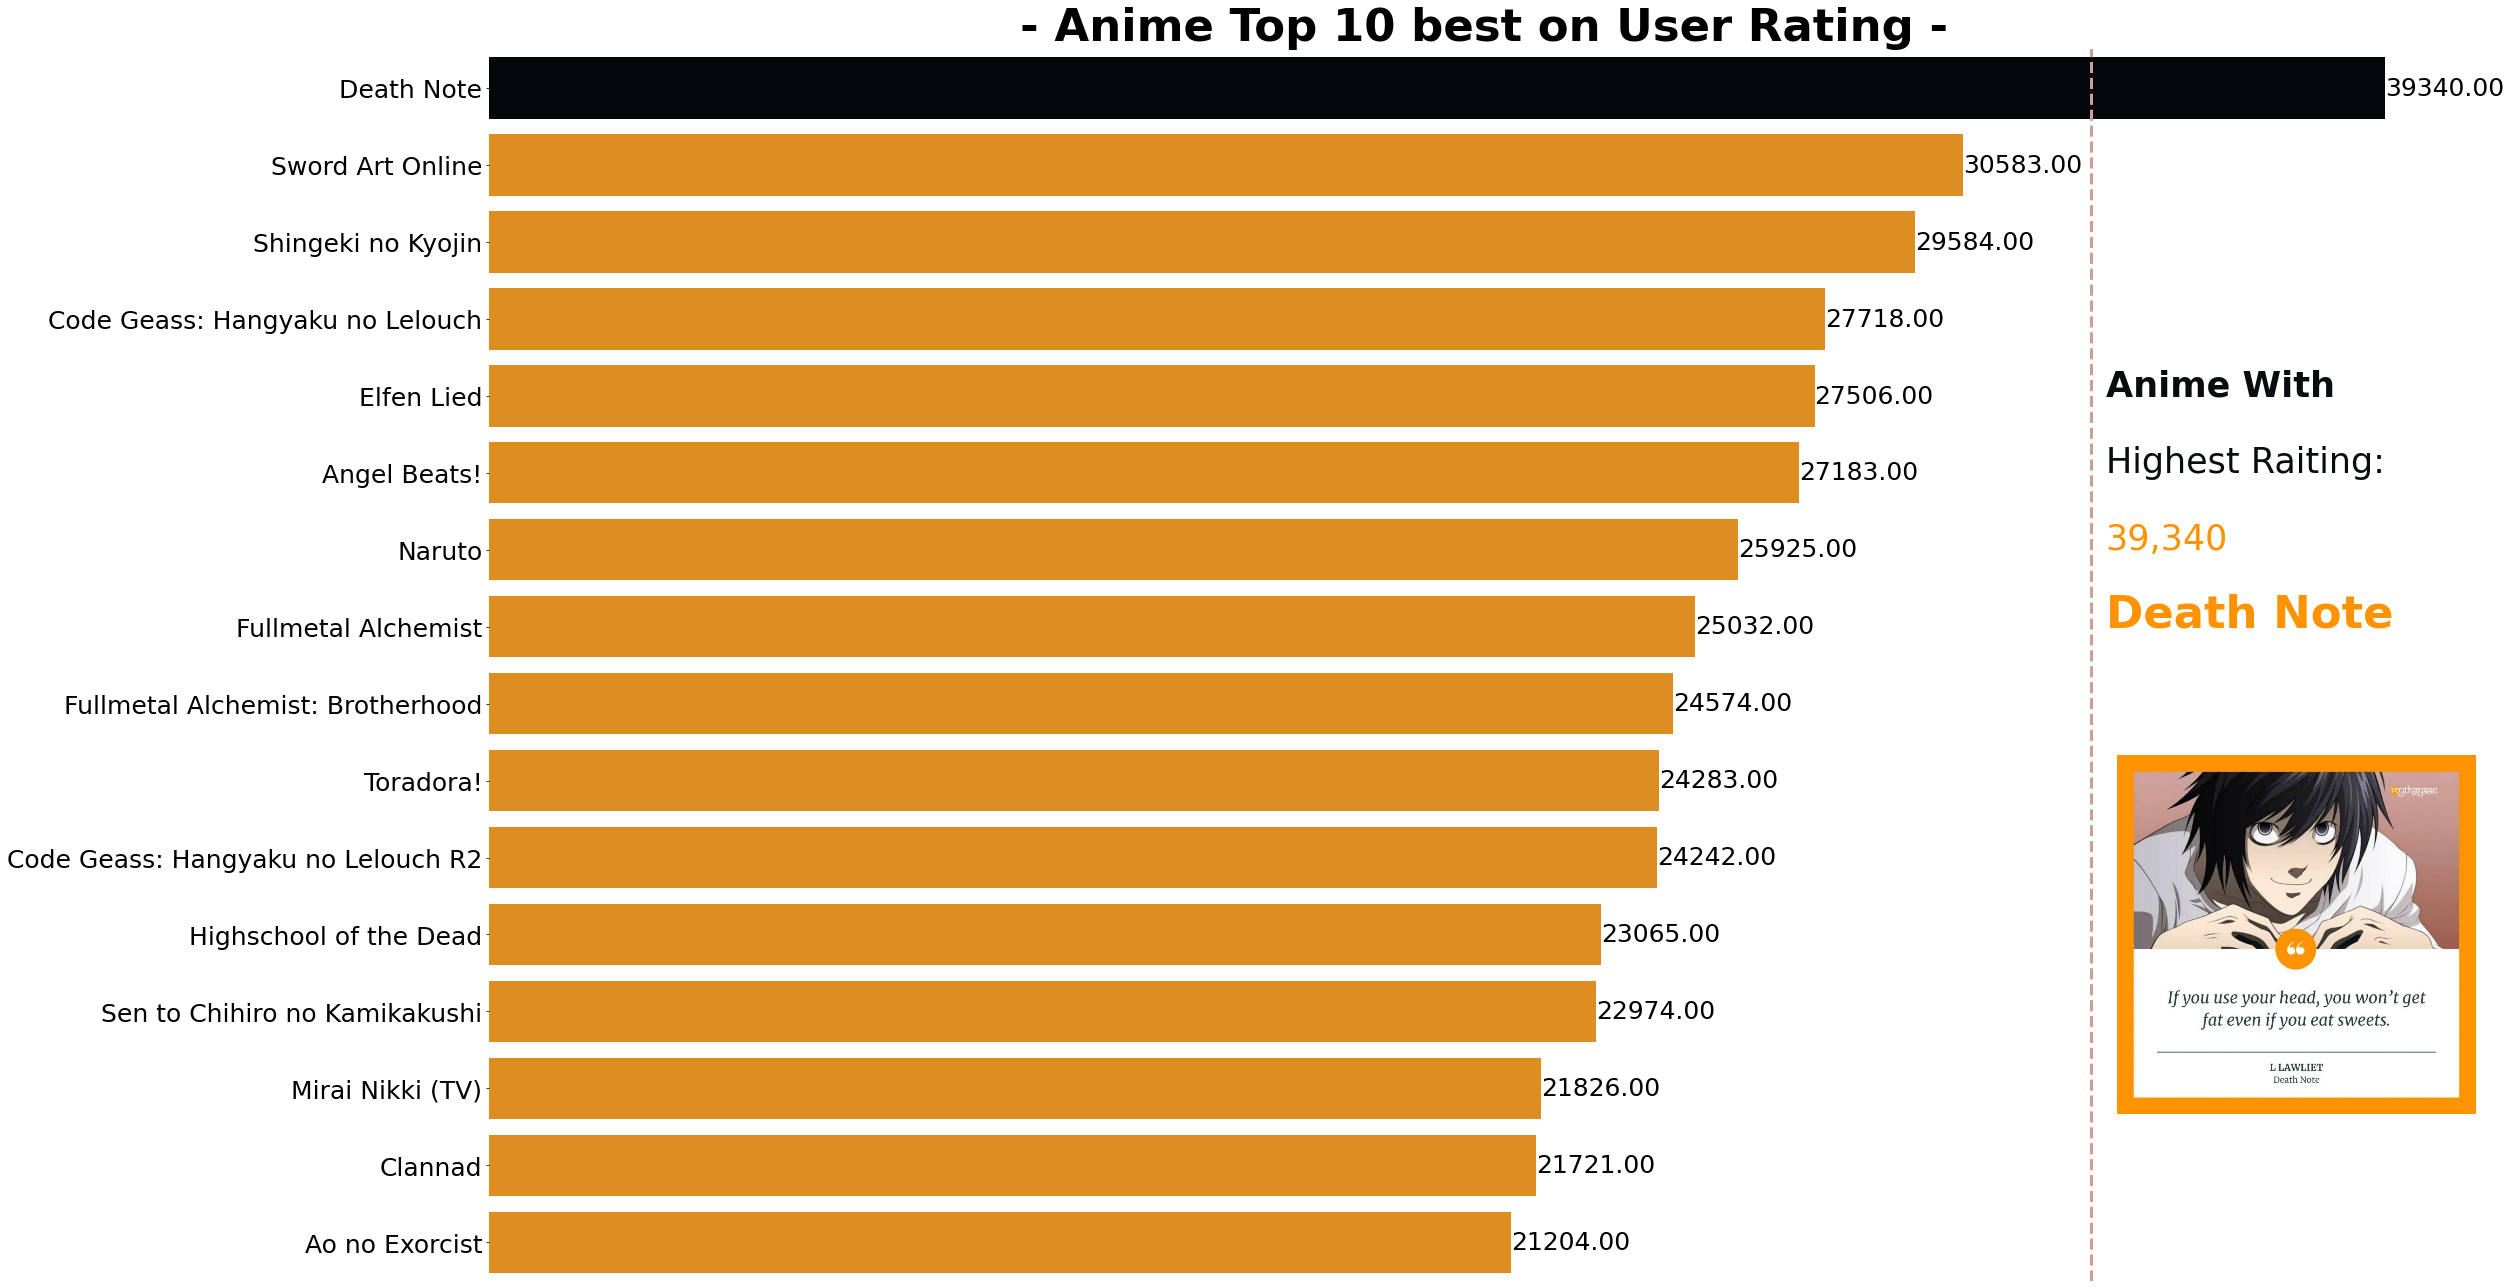

<Figure size 432x288 with 0 Axes>

In [14]:

# Creating a dataframe for rating counts
combine_anime_rating = df.dropna(axis = 0, subset = ['anime_title'])
anime_ratingCount = (combine_anime_rating.
     groupby(by = ['anime_title'])['user_rating'].
     count().
     reset_index().rename(columns = {'rating': 'totalRatingCount'})
    [['anime_title', 'user_rating']])

# Plot
fig, ax = plt.subplots(figsize=(35, 18))
plt.title('- Anime Top 10 best on User Rating -', size=45, weight="bold")
top10_animerating=anime_ratingCount[['anime_title', 'user_rating']].sort_values(by = 'user_rating',
                                                                                ascending = False).head(16)

# For differentiate top value with all other value
clrs = ['#03070B' if x==max(top10_animerating["user_rating"]) else "#FE9200" 
        for x in top10_animerating["user_rating"]]

sns.barplot(y="anime_title", x="user_rating", data=top10_animerating, orient='h', palette=clrs)
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=25)

# removing border line
sns.despine(left=True,bottom=True);

# for showing value on chart
for p in ax.patches:
    width = p.get_width()    
    ax.text(width + 1,p.get_y() + p.get_height() / 2, 
            '{:1.2f}'.format(width), 
            ha = 'left',   
            va = 'center',size=25) 
    
# Add Line on plot
plt.axvline(x=33250.00,ymin=0,ymax=15,color='#CE9D95',ls='--', lw=3)

# Add Text on plot
plt.text(x=33550, y=4, s="Anime With", fontweight='bold',
         color='#0A0D10', size=35)
plt.text(x=33550, y=5, s="Highest Raiting:",
         color='#0A0D10', size=35)

plt.text(x=33550, y=6, s="39,340",
         color='#FE9200', size=35)

plt.text(x=33550, y=7, s="Death Note", fontweight='bold',
         color='#FE9200', size=45)

#Insert Image using Function
insert_image(path="/kaggle/input/imagesused/DeathNte.jpg", zoom=0.35, 
             xybox=(37500, 11), ax=ax)
plt.tight_layout()
plt.show()
plt.savefig("top_15_anime_base_on_user_rating_orange.png", dpi=500)


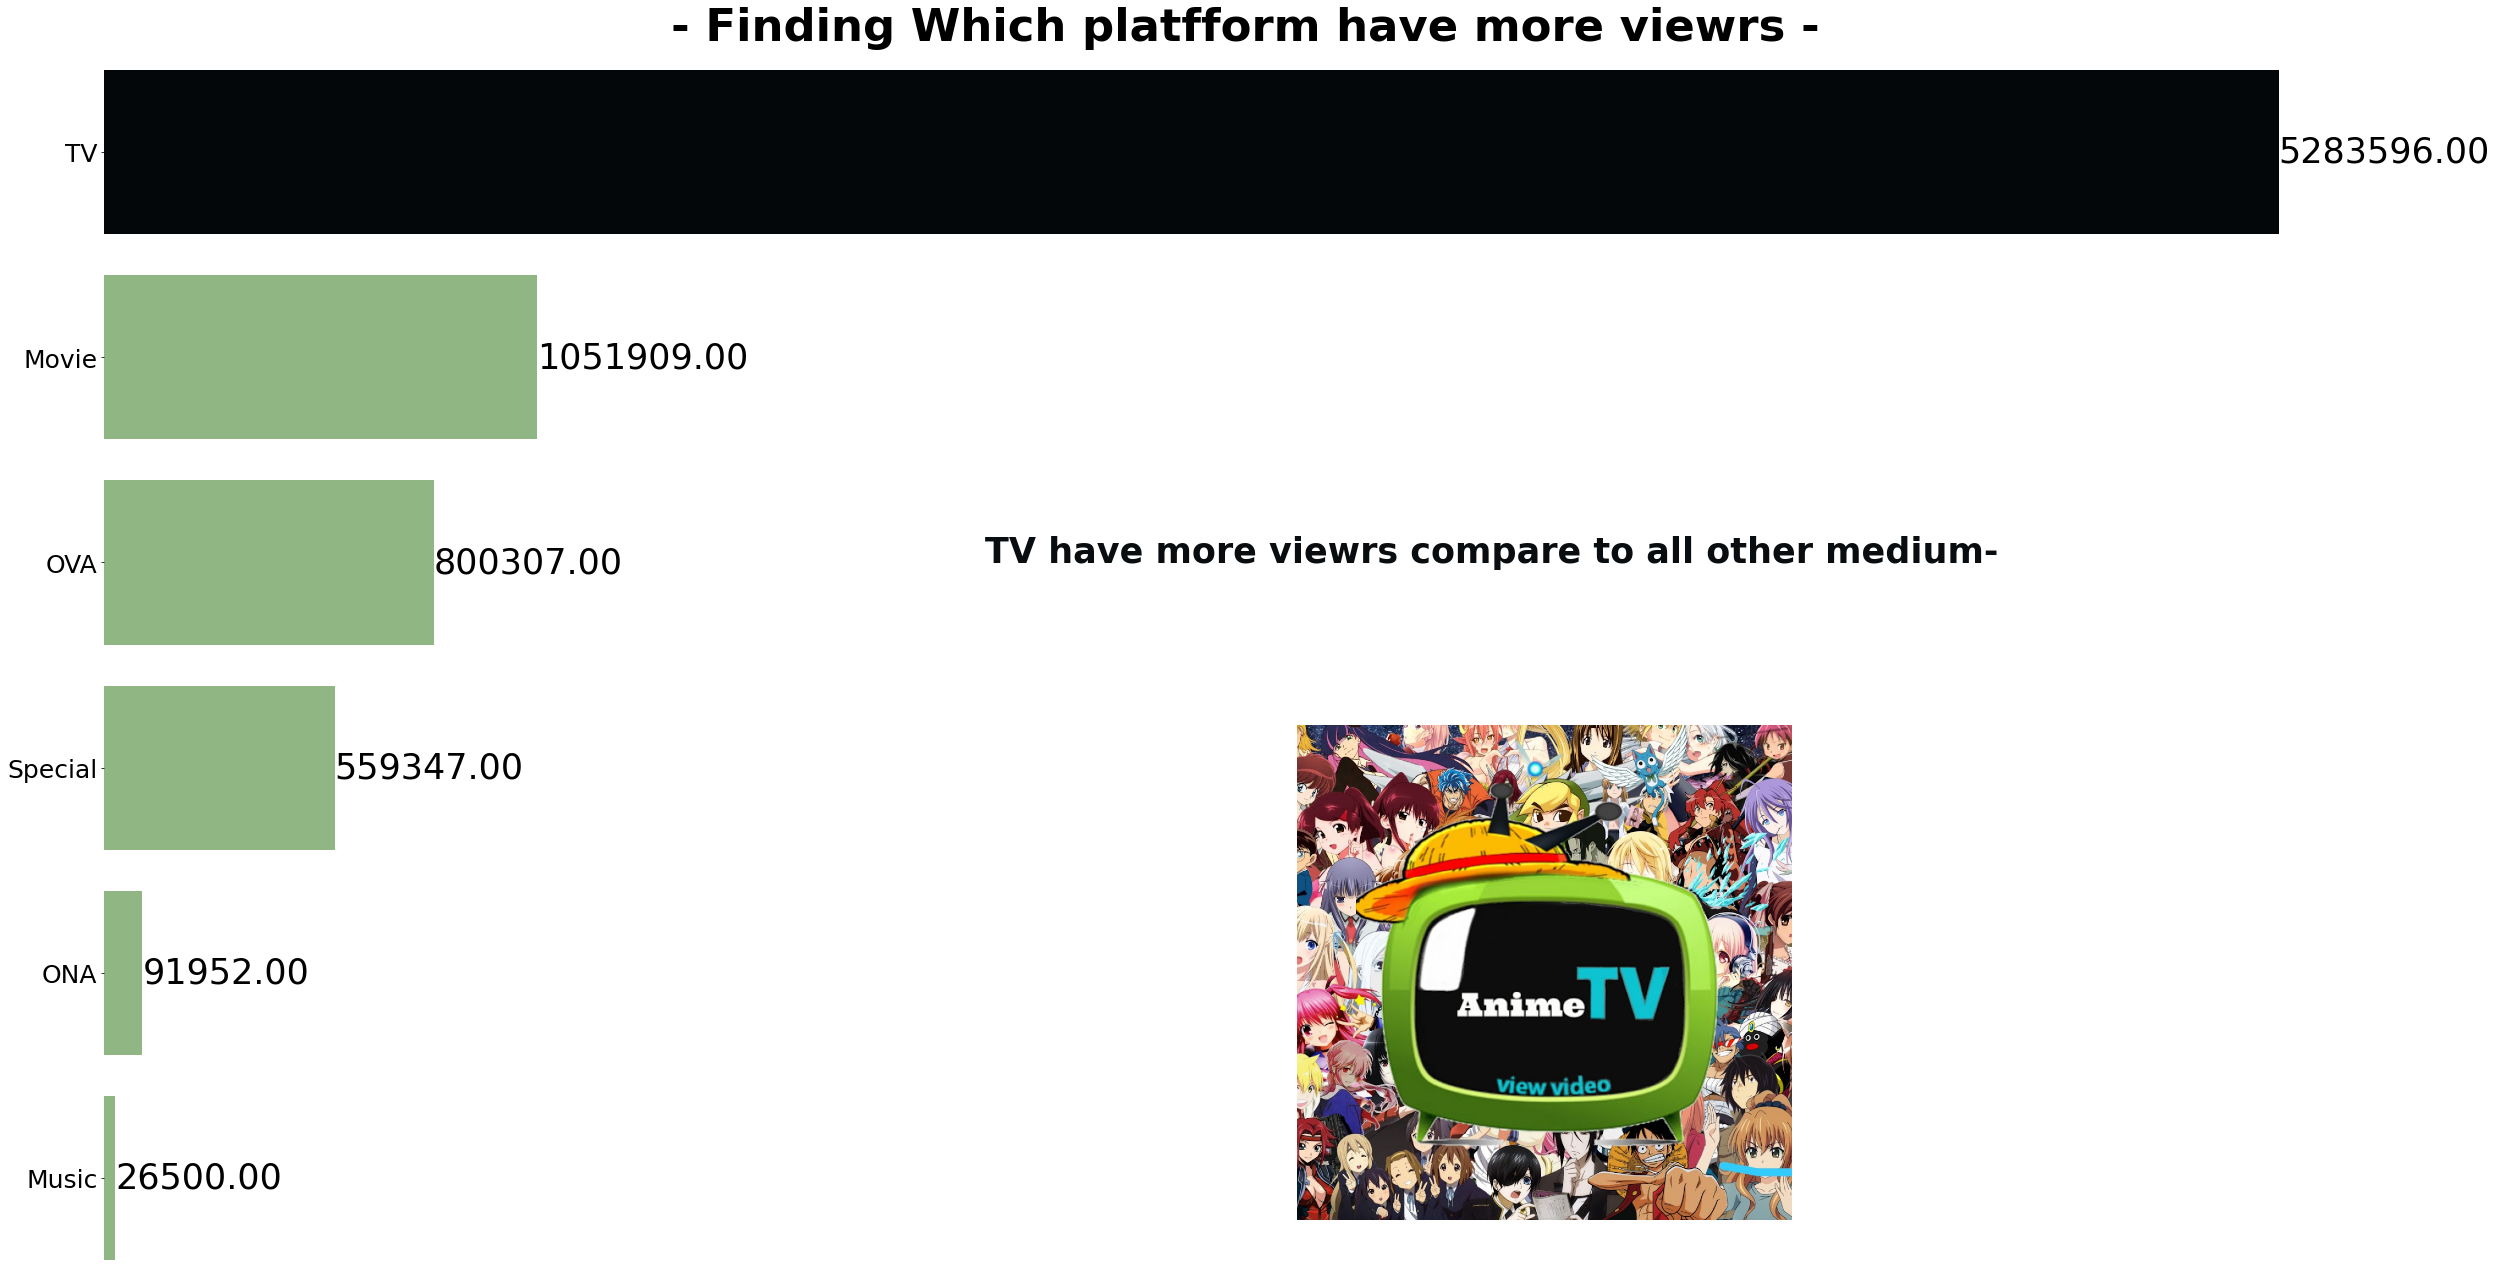

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot
fig, ax = plt.subplots(figsize=(35, 18))
plt.title('- Finding Which platfform have more viewrs -', size=45, weight="bold")

# For differentiate top value with all other value
clrs = ['#03070B' if x==max(df['type'].value_counts()) else "#8ABE7B" 
        for x in df['type'].value_counts()]

sns.countplot(y ='type', data = df, palette=clrs,order = df['type'].value_counts().index)
plt.ylabel("")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=25)
for p in ax.patches:
    width = p.get_width()    
    ax.text(width + 1,p.get_y() + p.get_height() / 2, 
            '{:1.2f}'.format(width), 
            ha = 'left',   
            va = 'center',size=35) 
        
# removing border line
sns.despine(left=True,bottom=True);
insert_image(path="/kaggle/input/imagesused/ANimeTV.jpg", zoom=0.55, 
             xybox=(3500000, 4), ax=ax)

# Add Text on plot
plt.text(x=2140000, y=2, s="TV have more viewrs compare to all other medium-", fontweight='bold',
         color='#0A0D10', size=35)

plt.tight_layout()
plt.show()
plt.savefig("best_platform_for_more_view.png", dpi=500)


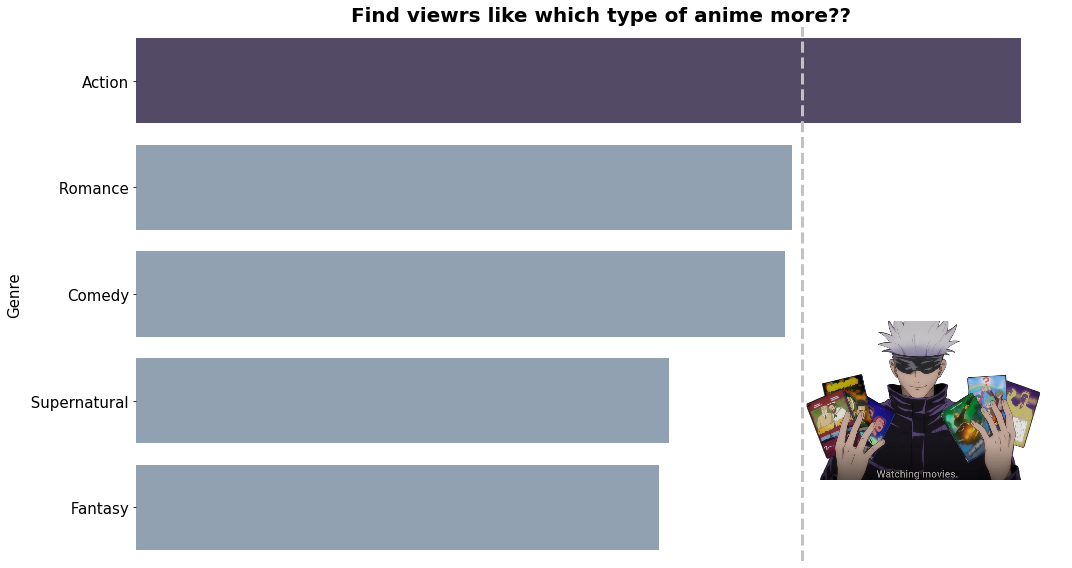

<Figure size 432x288 with 0 Axes>

In [16]:
# Split the "genre" column into multiple rows and count the occurrence of each genre
genre_counts = df['genre'].str.split(',').explode().value_counts()

# Select the top 5 genres
top_5 = genre_counts.head(5)

colors = ['#8CA1B7' if x!=max(top_5.values) else '#52456A' for x in top_5.values]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(15, 8))
plt.title("Find viewrs like which type of anime more??", size=20, weight="bold")
sns.barplot(x=top_5.values, y=top_5.index,palette=colors)
plt.axvline(x=2455000,ymin=0,ymax=5,color='#C3C1C3',ls='--', lw=3)
plt.xlabel("", size=15)
plt.ylabel("Genre", size=15)
plt.xticks([])
plt.yticks(size=15)
#Insert Image using Function
insert_image(path='/kaggle/input/imagesused/gojo.png', zoom=0.35, 
             xybox=(2900000, 3), ax=ax)

sns.despine(left=True,bottom=True);
plt.tight_layout()
plt.show()
plt.savefig("Which_type_of_anime_viewr_like.png", dpi=500)


In [17]:
top_5.values

array([3263393, 2418338, 2391327, 1963985, 1928965])

In [18]:
top_5.index.max()

'Comedy'

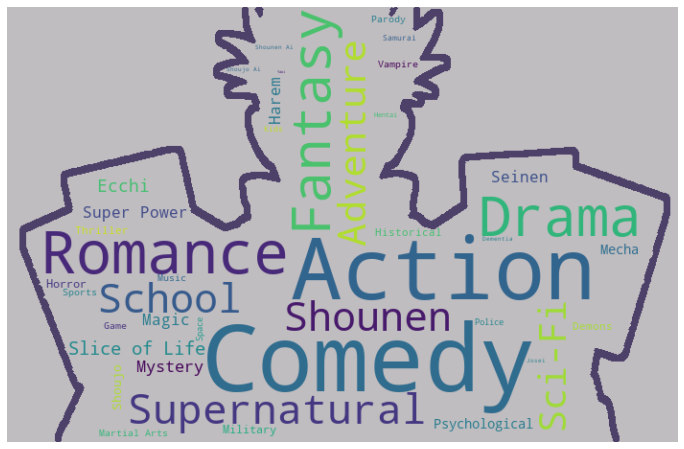

In [19]:

mask=np.array(Image.open("/kaggle/input/imagesused/gojo.png"))
df1=df.copy()
df1.dropna(inplace=True)

all_type_genres = defaultdict(int)

for genres in df1['genre']:
    for genre in genres.split(','):
        all_type_genres[genre.strip()] += 1
        


mwc=WordCloud(background_color="#C0BDC0",mask=mask,width=mask.shape[1],
               height=mask.shape[0],contour_width=7,
               contour_color='#4D4069')
mwc.generate_from_frequencies(all_type_genres)
plt.figure(figsize=(15, 8), facecolor = None)
plt.imshow(mwc, interpolation="bilinear")
plt.axis('off')
plt.show()

=== Rating Distribution ===
Maximum Rating is: 9.5 
Minimum Rating is: 1.67 
Average Rating is: 7.653157627120166 



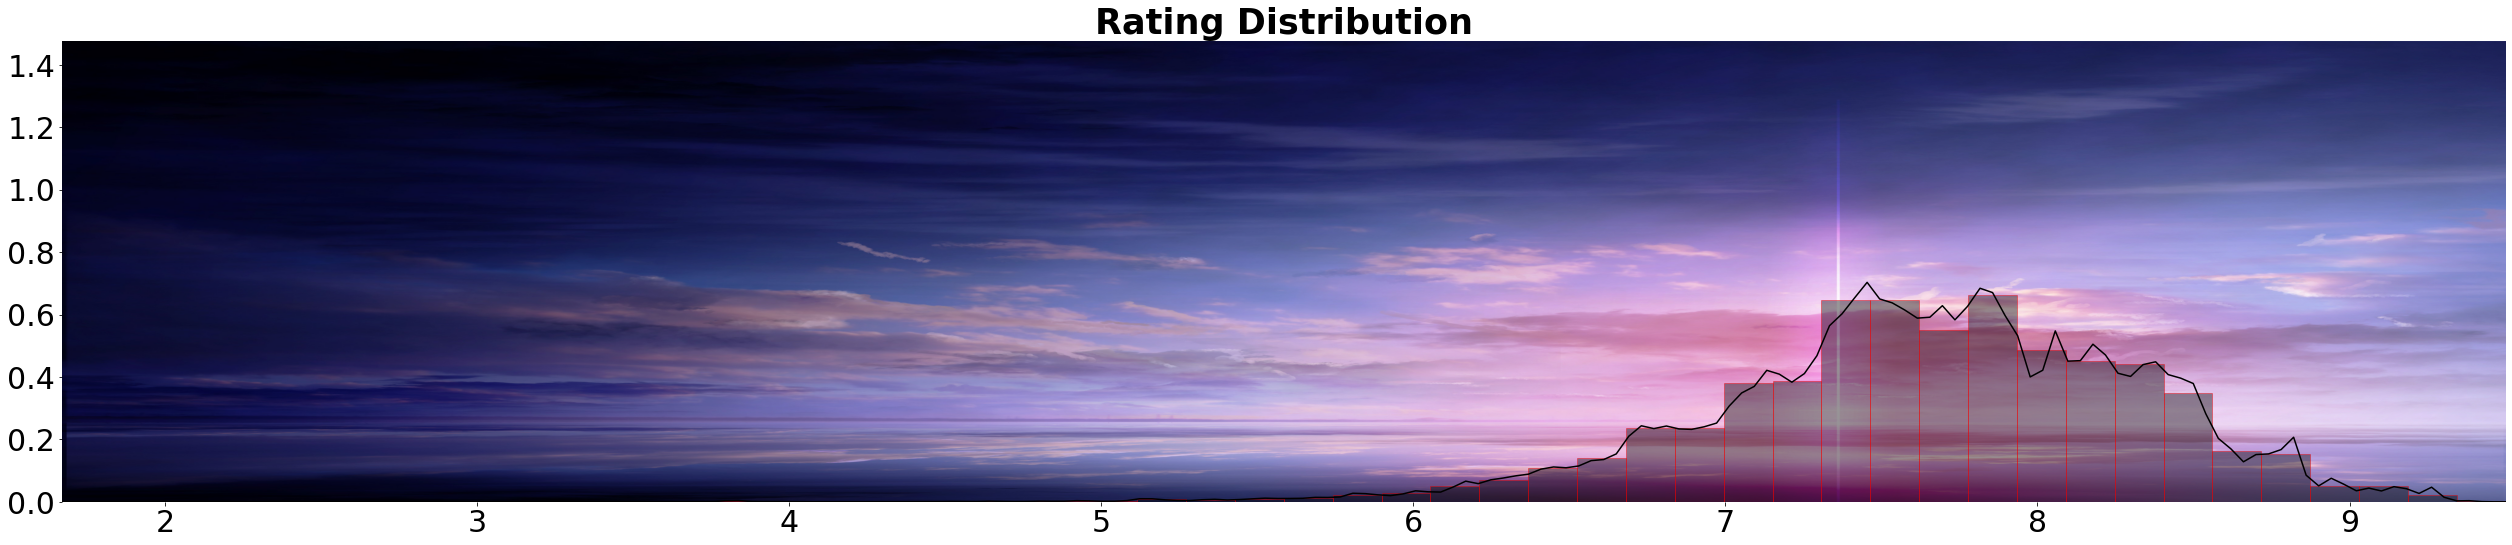

In [20]:
# Load the background image
im = plt.imread("/kaggle/input/imagesused/background.jpg")
print(clr.S+"=== Rating Distribution ==="+clr.E)
print(clr.S+"Maximum Rating is:"+clr.E, df["rating"].max(), "\n" +
      clr.S+"Minimum Rating is:"+clr.E, df["rating"].min(), "\n" +
      clr.S+"Average Rating is:"+clr.E, df["rating"].mean(), "\n")

fig, ax = plt.subplots(figsize=(35, 28))
ax1 = plt.subplot(1,1,1)
sns.distplot(df['rating'], color='black', ax=ax1, hist_kws=dict(edgecolor='red'))
ax1.set_title("Rating Distribution", size=35, weight="bold")
ax1.set_ylabel("")
ax1.set_xlabel("")
plt.subplots_adjust(hspace=1.2)
sns.despine(left=True, bottom=True)
plt.xticks(size=30)
plt.yticks(size=30)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.9)
sns.despine(left=True,bottom=True)

# Add the background image to the plot 
plt.imshow(im, extent=(df["rating"].min(), df["rating"].max(), 0, ax1.get_ylim()[1] * 2), zorder=-1)

plt.tight_layout()
plt.show()


In [21]:
print(clr.S+"=== What We Get From This ==="+clr.E)
print(clr.S+"Most of the rating is between:"+clr.E, "8-8.5", "\n" +
      clr.S+"And distribution are :"+clr.E, 'left skewed', "\n" )

=== What We Get From This ===
Most of the rating is between: 8-8.5 
And distribution are : left skewed 



=== User Rating Distribution ===
Maximum User Rating is: 10 
Minimum User Rating is: -1 
Average User Rating is: 6.144074743418888 



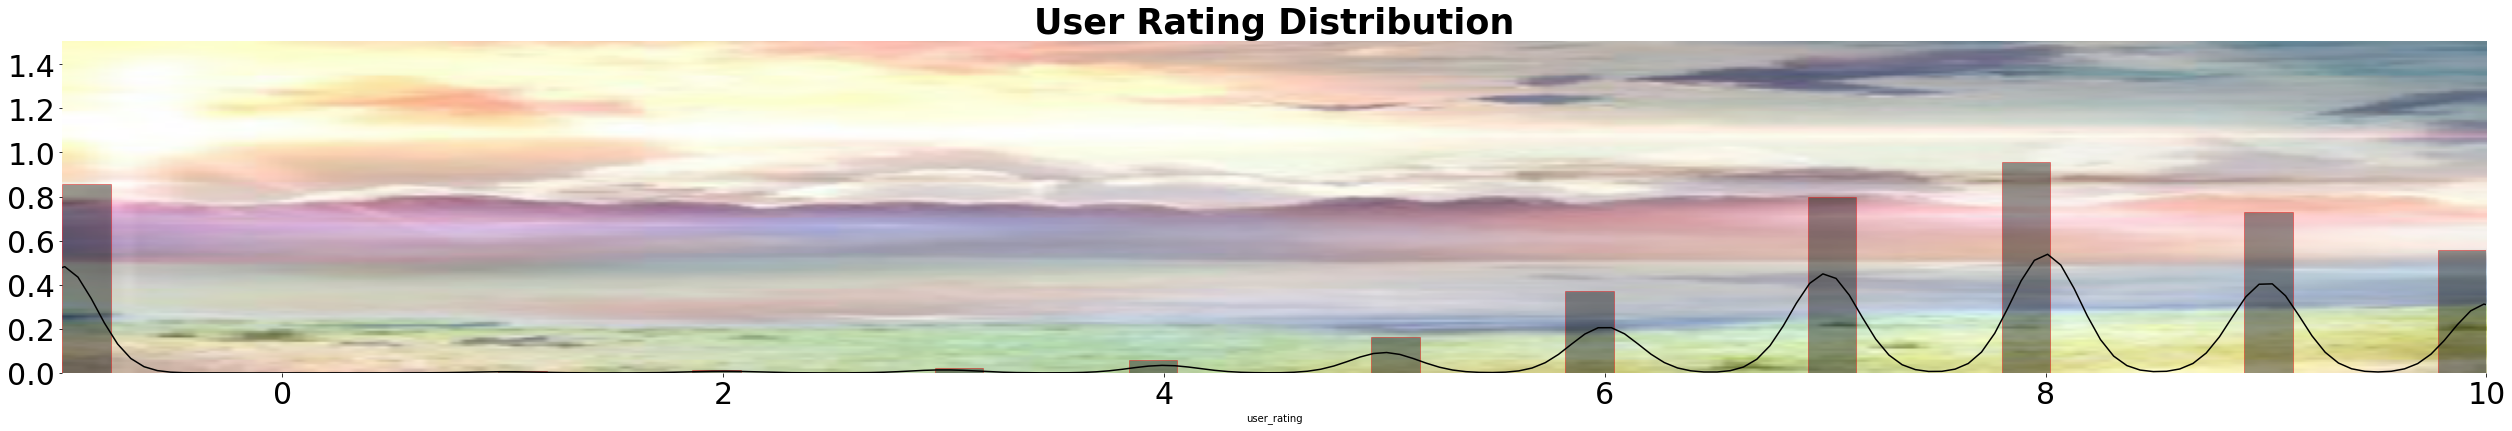

<Figure size 432x288 with 0 Axes>

In [22]:
# Load the background image
im = plt.imread("/kaggle/input/imagesused/bg.jpg")
print(clr.S+"=== User Rating Distribution ==="+clr.E)
print(clr.S+"Maximum User Rating is:"+clr.E, df["user_rating"].max(), "\n" +
      clr.S+"Minimum User Rating is:"+clr.E, df["user_rating"].min(), "\n" +
      clr.S+"Average User Rating is:"+clr.E, df["user_rating"].mean(), "\n")

fig, ax = plt.subplots(figsize=(35, 28))
ax1 = plt.subplot(1,1,1)
sns.distplot(df['user_rating'], color='black', ax=ax1, hist_kws=dict(edgecolor='red'))
ax1.set_title("User Rating Distribution", size=35, weight="bold")
ax1.set_ylabel("")
sns.despine(left=True, bottom=True)
plt.xticks(size=30)
plt.yticks(size=30)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
sns.despine(left=True,bottom=True)

# Add the background image to the plot
plt.imshow(im, extent=(df['user_rating'].min(), df['user_rating'].max(),0, ax1.get_ylim()[1] * 1.5), zorder=-1)

plt.tight_layout()
plt.show()
plt.savefig("user_rating_distribution.png", dpi=500)


In [23]:
print(clr.S+"=== What We Get From This ==="+clr.E)
print(clr.S+"Most of the rating is between:"+clr.E, "7-8", "\n" +
      clr.S+"And distribution are :"+clr.E, 'left skewed', "\n" +
      clr.S+"And we found outlier :"+clr.E, "-1", "\n" 
     )

=== What We Get From This ===
Most of the rating is between: 7-8 
And distribution are : left skewed 
And we found outlier : -1 



In [24]:
print(clr.S+"=== DATA PREPROCESSING ==="+clr.E)

=== DATA PREPROCESSING ===


In [25]:
df_final = df.copy()
df_final["user_rating"].replace(to_replace = -1 , value = np.nan ,inplace=True)
df_final = df_final.dropna(axis = 0)
print(clr.S+"Null values after final pre-processing :"+clr.E)
df_final.isna().sum()

Null values after final pre-processing :


anime_id       0
anime_title    0
genre          0
type           0
episodes       0
rating         0
members        0
user_id        0
user_rating    0
dtype: int64

In [26]:
users_with_more_than_100_rating = df_final["user_id"].value_counts()
df_final = df_final[df_final["user_id"].isin(users_with_more_than_100_rating[users_with_more_than_100_rating >= 10].index)]

In [27]:
print(clr.S+"=== Cleaning Anime Title  ==="+clr.E)

=== Cleaning Anime Title  ===


In [28]:
import re
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

df_final["anime_title"] = df_final["anime_title"].apply(text_cleaning)

In [29]:
print(clr.S+"=== Create Modeling  ==="+clr.E)

=== Create Modeling  ===


In [30]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

# Filling NaNs with empty string
anime_df['genre'] = anime_df['genre'].fillna('')

genres_str = anime_df['genre'].str.split(',').astype(str)

tfv_matrix = tfv.fit_transform(genres_str)

In [31]:
#  sigmoid kernel
sigmoid_kernel_anime = sigmoid_kernel(tfv_matrix, tfv_matrix)

indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()

def give_recommendation(title, sigmoid_kernel_anime=sigmoid_kernel_anime):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sigmoid_kernel_anime[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:16]

    # Movie indices
    anime_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Rating': anime_df['rating'].iloc[anime_indices].values})

<div style="text-align:center;">
<img src="https://vignette.wikia.nocookie.net/marvelcrossroads/images/d/d9/Naruto_(62005).png/revision/latest?cb=20161115053653" alt="Naruto" style="width:200px;height:300px;">
</div>

In [32]:
print(clr.S+"Naruto is my favourite anime so let's check for that"+clr.E)

Naruto is my favourite anime so let's check for that


Recommendations for Naruto Shippuuden:


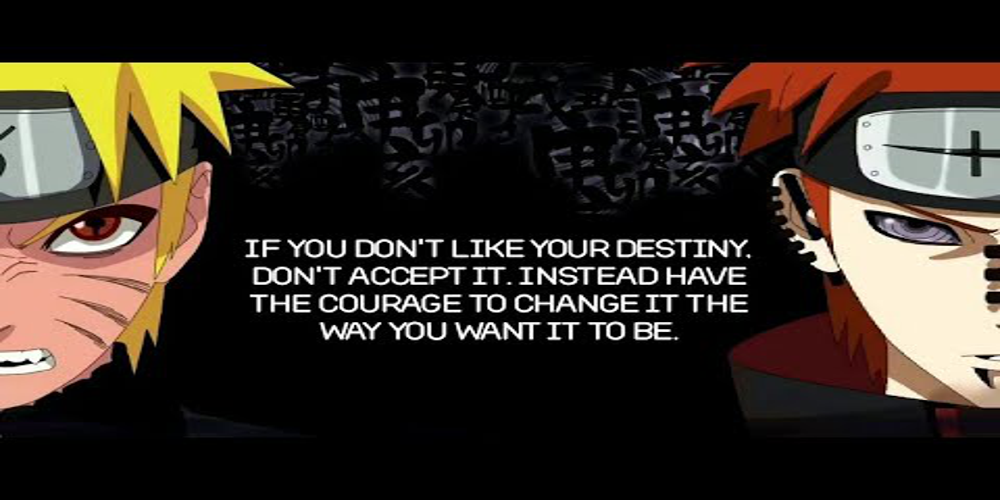

In [33]:
print(clr.S+"Recommendations for Naruto Shippuuden:"+clr.E)
table=give_recommendation('Naruto: Shippuuden')
display.display(table.style.set_properties(**{'border-style': 'solid', 'border-width': '1px'}).set_table_styles([{'selector': 'th','props': [('background-color', '#968C9F'), ('color', 'white')]}]))
# Open an image
img = Image.open("/kaggle/input/imagesused/Naruto.jpg")
img = img.resize((1000, 500))
# Display the image
display.display(img)

In [34]:
print(clr.S+"Let's find for top 3 anime:"+clr.E)
top10_animerating.head(3)

Let's find for top 3 anime:


anime_title  user_rating
1828          Death Note        39340
9487    Sword Art Online        30583
8836  Shingeki no Kyojin        29584

Recommendations for Death Note:


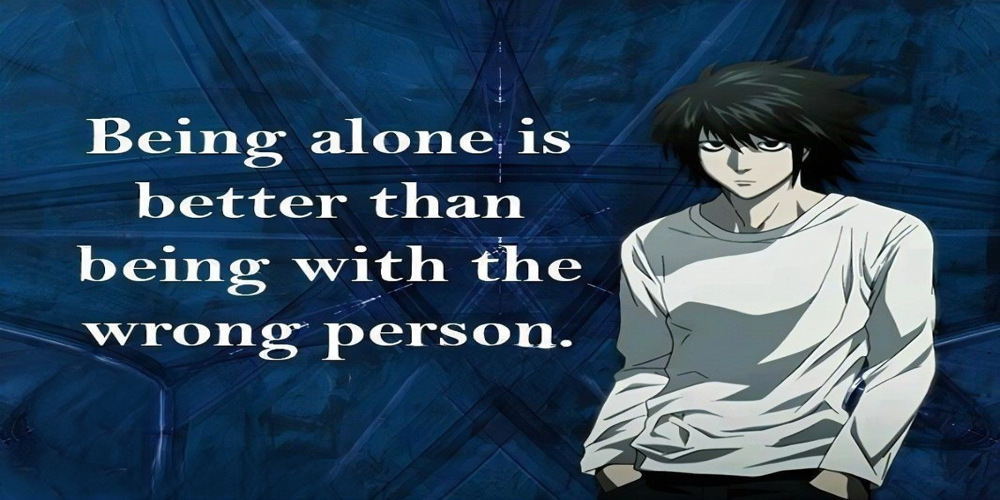

In [35]:
print(clr.S+"Recommendations for Death Note:"+clr.E)
table=give_recommendation('Death Note')
display.display(table.style.set_properties(**{'border-style': 'solid', 'border-width': '1px'}).set_table_styles([{'selector': 'th','props': [('background-color', '#0A365C'), ('color', '#EFEEEF')]}]))
# Open an image
img = Image.open("/kaggle/input/imagesused/deathnote_.jpg")
img = img.resize((1000, 500))
# Display the image
display.display(img)

Recommendations for Shingeki no Kyojin:


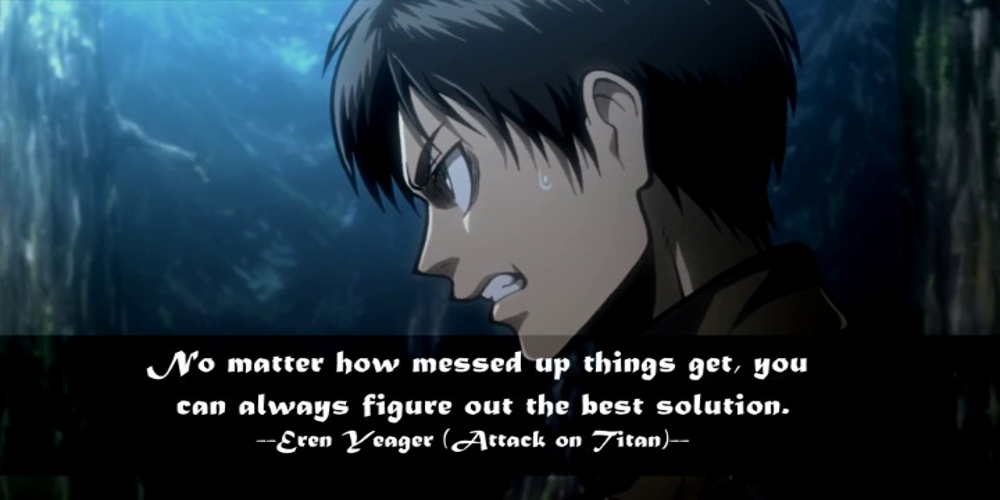

In [36]:
print(clr.S+"Recommendations for Shingeki no Kyojin:"+clr.E)
table=give_recommendation('Shingeki no Kyojin')
display.display(table.style.set_properties(**{'border-style': 'solid', 'border-width': '1px'}).set_table_styles([{'selector': 'th','props': [('background-color', 'black'), ('color', '#EFEEEF')]}]))
# Open an image
img = Image.open("/kaggle/input/imagesused/eren.png")
img = img.resize((1000, 500))
# Display the image
display.display(img)

Recommendations for Sword Art Online


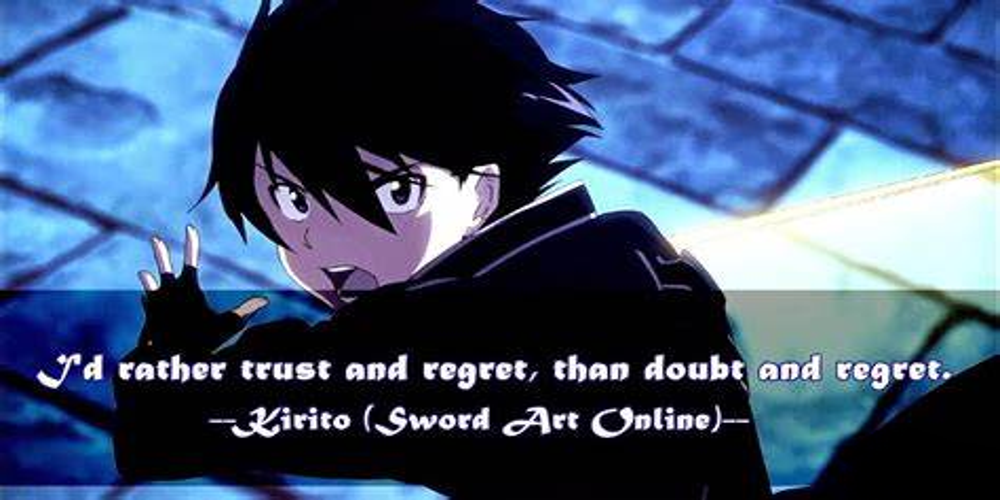

In [37]:
print(clr.S+"Recommendations for Sword Art Online"+clr.E)
table=give_recommendation('Sword Art Online')
display.display(table.style.set_properties(**{'border-style': 'solid', 'border-width': '1px'}).set_table_styles([{'selector': 'th','props': [('background-color', '#7AD0FE'), ('color', '#040505')]}]))
# Open an image
img = Image.open("/kaggle/input/imagesused/Sword Art Online.jfif")
img = img.resize((1000, 500))
# Display the image
display.display(img)

In [38]:

HTML('<div style="position: relative; width: 100%; height: 0; padding-top: 56.2500%; padding-bottom: 0; box-shadow: 0 2px 8px 0 rgba(63,69,81,0.16); margin-top: 1.6em; margin-bottom: 0.9em; overflow: hidden; border-radius: 8px; will-change: transform;"> <iframe loading="lazy" style="position: absolute; width: 100%; height: 100%; top: 0; left: 0; border: none; padding: 0;margin: 0;" src="https://www.canva.com/design/DAFaG232RRg/view?embed" allowfullscreen="allowfullscreen" allow="fullscreen"> </iframe> </div> <a href="https://www.canva.com/design/DAFaG232RRg/view?utm_content=DAFaG232RRg&utm_campaign=designshare&utm_medium=embeds&utm_source=link" target="_blank" rel="noopener">Anime Recommendation System</a> by enil')


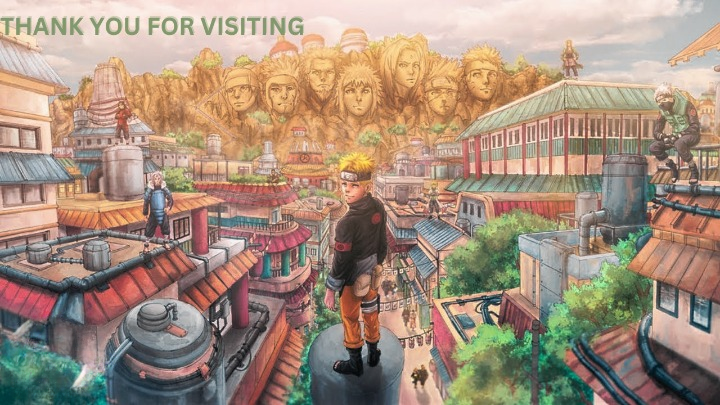

In [39]:
# Open an image
img = Image.open("/kaggle/input/imagesused/ANIME Recommendation System.png")

# Display the image
display.display(img)
